# Week 8 - Semantic Networks - Bayesian Echo Chamber

This week, we explore the representation and analysis of semantic networks. A word or document network is an unsupervized representation of text akin to a clustering or an embedding, but semantic networks can also be defined using semantic or syntactic information derived from methods we have used earlier in the quarter. For example, we can define links between words as a function of their co-presence within a document, chapter, paragraph, sentence, noun phrase or continuous bag of words. We can also define links as a function of words that rely on one another within a directed dependency parse, or links between extracted Subjects, Verbs and Objects, or nouns and the adjectives that modify them (or verbs and the adverbs that modify *them*). Rendering words linked as a network or discrete topology allows us to take advantage of the wide range of metrics and models developed for network analysis. These include measurement of network centrality, density and modularity, "block modeling" structurally equivalent relationships, andsophisticated graphical renderings of networks or network partitions that allow us to visually interrogate their structure and complexity.

For this notebook we will use the following packages:

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip

#This will be doing most of the work
import networkx as nx

import nltk #For POS tagging
import sklearn #For generating some matrices
import pandas as pd#For DataFrames
import numpy as np #For arrays
import matplotlib.pyplot as plt #For plotting
import seaborn #MAkes the plots look nice

import pickle #if you want to save layouts
import os

%matplotlib inline

We will primarily be dealing with graphs in this notebook, so lets first go over how to use them.

To start with lets create an undirected graph:

In [2]:
g = nx.Graph()
g

We can add nodes. These are all named, like entries in a dict.

In [3]:
g.add_node(1)
g.add_node(2)
g.add_node(3)

Now we have 3 vertices:

In [4]:
len(g.nodes)

3

Or if we want to get more information about the graph:

In [5]:
print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 3
Number of edges: 0
Average degree:   0.0000


We can give nodes properties, like name or type

In [6]:
g.nodes[1]

{}

In [7]:
g.nodes[1]['type'] = 'NN'

In [8]:
g.nodes[1]

{'type': 'NN'}

Still pretty boring though...

Lets add a couple of edges. Notice that we use the ids not any of the properties:

In [9]:
g.add_edges_from([(1, 2), (2, 3), (3, 1), (1,4)])
print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 4
Number of edges: 4
Average degree:   2.0000


Note how the summary has changed. Also there's one more node, since we asked for an edge to 4,

We can also give the edges properties like weights:

In [10]:
g.edges[1, 2]['weight'] = 2
g.edges[1, 4]['weight'] = 2
g.edges[1, 4]

{'weight': 2}

Let's visualize it now:

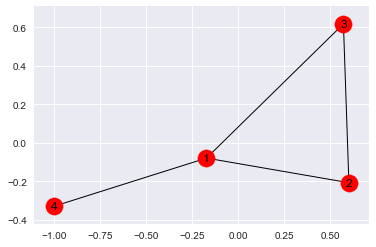

In [11]:
nx.draw_networkx(g)

Very exciting :-).

There are a great many things to do with the graph once we have created it, some of which we will explore today.

First lets load our data, the Grimmer corpus:

In [12]:
senReleasesDF = pandas.read_csv('../data/senReleasesTraining.csv', index_col = 0)
senReleasesDF[:3]

,download_url,html_url,name,path,text,targetSenator
0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2005Kennedy12.txt,raw/Kennedy/01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy10.txt,raw/Kennedy/01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy


We will be extracting sentences, as well as tokenizing and stemming. (You should be able to do this in your sleep now)

For now we will not be dropping any stop words:

In [13]:
senReleasesDF['tokenized_sents'] = senReleasesDF['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
senReleasesDF['normalized_sents'] = senReleasesDF['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s, stopwordLst = None, stemmer = lucem_illud.stemmer_basic) for s in x])

Let's start by looking at words co-occurring in the same sentences:

In [14]:
def wordCooccurrence(sentences, makeMatrix = False):
    words = set()
    for sent in sentences:
        words |= set(sent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in sentences:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        return g    

Build a graph based on word cooccurence in the first 10 press releases.

In [17]:
g = wordCooccurrence(senReleasesDF['normalized_sents'][:10].sum())

Total number of vertices:

In [18]:
len(g.nodes)

1052

Total number of edges:

In [19]:
len(g.edges)

220119

A part of the adjacency matrix of cleaned word by press releases:

In [20]:
nx.to_numpy_matrix(g)[:5, :5]

matrix([[2., 0., 0., 4., 0.],
        [0., 0., 0., 0., 3.],
        [0., 0., 0., 0., 0.],
        [4., 0., 0., 2., 0.],
        [0., 3., 0., 0., 8.]])

We can save the graph and read it later, although this is slow if there are lots of edges or nodes, so we will filter first.

In [21]:
#nx.write_graphml(g, '../data/Obama_words.graphml')

Or, we can build graphs starting with a two-mode network. Let's again use the document-word frequency matrix that we used in week 3.

In [22]:
def tokenize(text):
    tokenlist = nltk.word_tokenize(text)
    normalized = lucem_illud.normalizeTokens(tokenlist, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic)
    return normalized

In [25]:
senVectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)
senVects_incidence = senVectorizer.fit_transform(senReleasesDF['text'][:10])

In [26]:
senVects_incidence.shape

(10, 955)

We need to turn the incidence matrix into a network. Note the use of bipartite as an attribute, you need to use it to tell networkx the graph is bipartite.

In [65]:
g_2mode = nx.Graph()

#define all the nodes
g_2mode.add_nodes_from((senVectorizer.get_feature_names()[i] for i in range(senVects_incidence.shape[1])), bipartite = 'word')
g_2mode.add_nodes_from(range(senVects_incidence.shape[0]), bipartite = 'doc')

#add all the edges
g_2mode.add_edges_from(((d, senVectorizer.get_feature_names()[w], {'weight' : senVects_incidence[d, w]}) for d, w in zip(*senVects_incidence.nonzero())))

In [66]:
print(nx.info(g_2mode))

Name: 
Type: Graph
Number of nodes: 965
Number of edges: 1623
Average degree:   3.3637


A very popular layout algorithm for visualizing graphs is the Fruchterman-Reingold Algorithm (or spring layout), which uses a physical metaphor for lay-out. Nodes repel one another, and edges draw connected elements together like springs. The algorithm attempts to minimize the energy in such a system. For a large graph, however, the algorithm is computational demanding. The commented code gives you a layout and you can save it as a pickle. Let's then load a layout.

In [67]:
#These take a long time
#layout = nx.spring_layout(g_2mode)
#pickle.dump(layout, open( "layout.pkl", "wb" ) )
#layout = pickle.load(open('layout.pkl','rb'))

Then, let's plot the bipartite network with a quick spring layout:

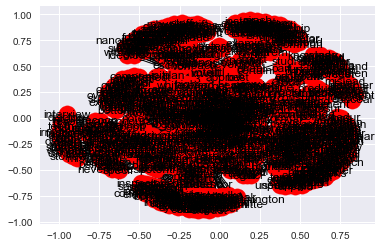

In [68]:
nx.draw_networkx(g_2mode)

If we want even faster computation and tunable visualizations, check out [Pajek](http://mrvar.fdv.uni-lj.si/pajek/) or [gephi](https://gephi.org/).

A two-mode network can be easily transformed into two one-mode network, enabling words to be connected to other words via the number of documents that share them, or documents to be connected to other documents via the words they share.

In [101]:
def contractNetwork(g, targetType):
    g_mono = nx.Graph()
    g_mono.add_nodes_from(((n, d) for n, d in g_2mode.nodes(data = True) if d['bipartite'] == targetType))
    
    for n_outside in (n for n, d in g_2mode.nodes(data = True) if d['bipartite'] != targetType):
        neighbors = list((n for n in g.neighbors(n_outside) if g.nodes[n]['bipartite'] == targetType))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                try:
                    g_mono.edges[n1, n2]['weight'] += 1
                except KeyError:
                    g_mono.add_edge(n1, n2, weight = 1)
    return g_mono
        
        

#gDoc = nx.bipartite.projected_graph(g_2mode, (n for n, d in g_2mode.nodes(data = True) if d['bipartite'] == 'doc'))

In [102]:
gDoc = contractNetwork(g_2mode, 'doc')

Let's first take a look at the document-to-document network:

In [103]:
print(nx.info(gDoc))

Name: 
Type: Graph
Number of nodes: 10
Number of edges: 45
Average degree:   9.0000


Let's do a visualization. It is not surprising that almost every document is connected to every one else. We can use edge weight to distinguish distance (modeled as attraction) between the nodes.

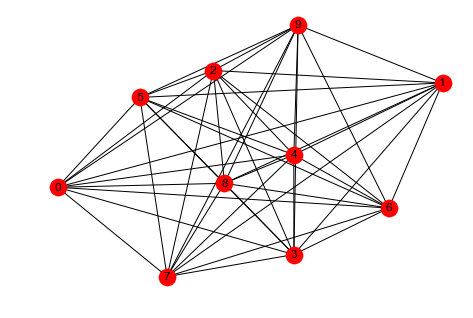

In [104]:
layout = nx.spring_layout(gDoc, k = 1/3, weight='weight', iterations= 50)
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}) #Getting labels is a bit annoying

Lets deaw the graph with high and low weight edges distinguished:

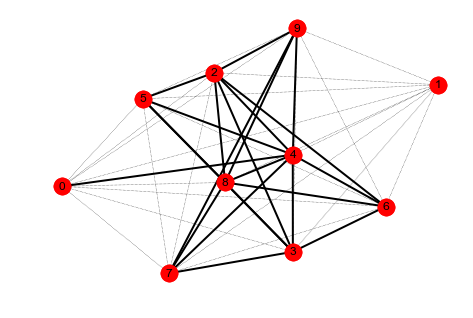

In [108]:
wMedian = np.median([d['weight'] for n1, n2, d in gDoc.edges(data = True)])
edgesHigh = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] > wMedian]
edgesLow = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] <= wMedian]
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}, edgelist = edgesLow, style='dotted', width=.5)
nx.draw(gDoc, pos = layout, nodelist=None, edgelist = edgesHigh, width=2)

Now we can see why 0 and 1 are on the outside

Now let's turn it around and look at the word-to-word network (via documents). 

In [110]:
gWord = contractNetwork(g_2mode, 'word')
print(nx.info(gWord))

Name: 
Type: Graph
Number of nodes: 955
Number of edges: 154965
Average degree: 324.5340


First, let's reduce the number of words to a manageable size.

In [114]:
wMean = np.mean([d['weight'] for n1, n2, d in gWord.edges(data = True)])
wMean

1.142032071758139

Lets drop all the edges with weight below 1, then drop all the isolates

In [120]:
gWord.remove_edges_from([(n1, n2) for n1, n2, d in gWord.edges(data = True) if d['weight'] <= 1])
gWord.remove_nodes_from(list(nx.isolates(gWord))) #since we are changing the graph list() evuluates the isolates first
print(nx.info(gWord))

Name: 
Type: Graph
Number of nodes: 334
Number of edges: 16974
Average degree: 101.6407


A bit smaller now

Now, let's visualize this:

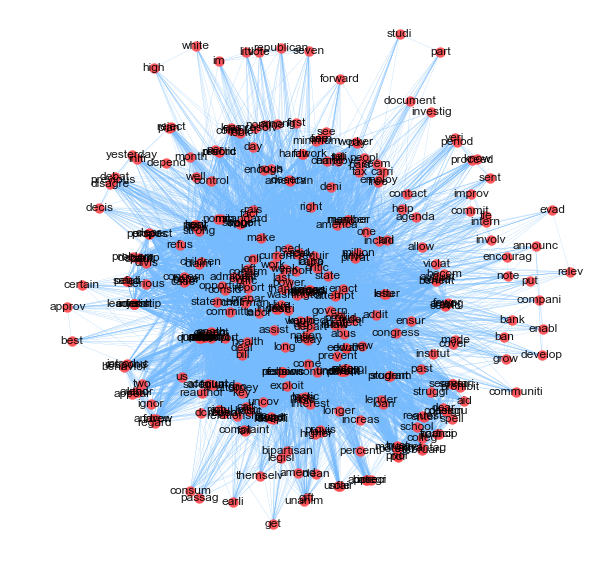

In [131]:
layout = nx.spring_layout(gWord, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(gWord, ax = ax, pos = layout, labels = {n:n for n in gWord.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

Still a bit messy, lets remove a few more edges

In [132]:
minWeight = 3
gWord.remove_edges_from([(n1, n2) for n1, n2, d in gWord.edges(data = True) if d['weight'] <= minWeight])
gWord.remove_nodes_from(list(nx.isolates(gWord))) #since we are changing the graph list() evuluates the isolates first
print(nx.info(gWord))

Name: 
Type: Graph
Number of nodes: 80
Number of edges: 936
Average degree:  23.4000


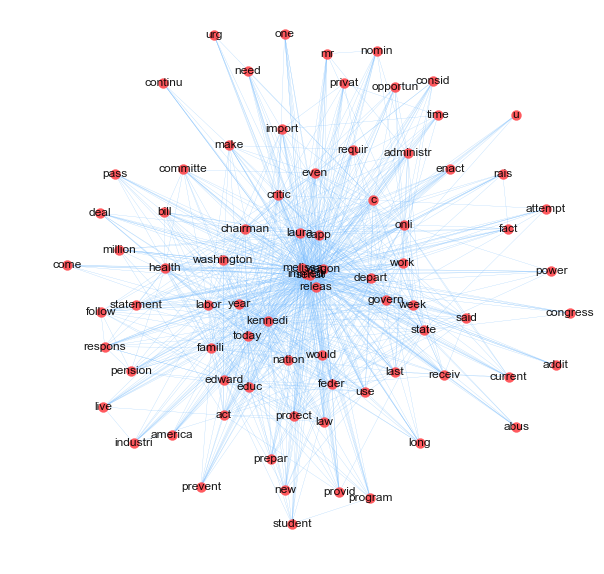

In [133]:
layout = nx.spring_layout(gWord, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(gWord, ax = ax, pos = layout, labels = {n:n for n in gWord.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

We can continue to trim globally or locally, to investigate the structure of words around a core word of interest.

#Can we do an example of this...visualize just the neighborhood of a word...e.g., the word and all words most closely connected and their close connections (friend of a friend)?

## <span style="color:red">*Your Turn*</span>

<span style="color:red">Construct cells immediately below this that render some reasonable networks to meaningfully characterize the structure of words and documents (or subdocuments like chapters or paragraphs) from your corpus. Also create some smaller, word neighborhood graphs. What are useful filters and thresholds and what semantic structures do they reveal that given insight into the social world and social game inscribed in your corpus?

Alternatively, there are some more informative networks statistics.

Lets begin with measures of centrality. The concept of centrality is that some nodes (words or documents) are more *central* to the network than others. There are many distinct and opposing operationalizations of this concept, however. One important concept is *betweenness* centrality, which distinguishes nodes that require the most shortest pathways between all other nodes in the network. Semantically, words with a high betweenness centrality may link distinctive domains, rather than being "central" to any one. 

In [ ]:
G_b.vs[np.argmax(G_b.betweenness())]

We can color and size the nodes by betweenness centrality:

In [ ]:
pal = ig.GradientPalette("red", "blue", G_b.vcount())
G_b.vs['color'] = [pal.get(int(v)) for v in np.argsort(G_b.betweenness())]
ig.plot(G_b, layout = layout, edge_width = 0.2)

The distrubution of betweenness centrality is:

In [ ]:
plt.hist(G_b.betweenness())
plt.show()

Or if we set a max of 500

In [ ]:
plt.hist([min(b, 500) for b in G_b.betweenness()])
plt.show()

This is an exponential distrubution.

Another way to visualize the graph involes the use of label sizes to represent betweenness centrality and edge widths to represent edge weight:

In [ ]:
edge_width = (np.array(G_b.es['weight'])*0.1).tolist()
size = (5 + np.sqrt(np.array(G_b.betweenness()))).tolist()
ig.plot(G_b, layout = layout, vertex_size = 0, vertex_label_size = size, edge_width = edge_width)

Here it appears that "health"/"drug", "torture"/"Iraq", and "loan"/"lend" are key concepts that connect others in the broader network. This is interesting in that they seem to be a domain-specific rather than linking words like "require" and "govern".

What are the top ten words in terms of betweenness?

In [ ]:
sorted(zip(G_b.vs['name'], G_b.betweenness()), key = lambda x: x[1], reverse = True)[:10]

What are words further down (the lowest all have centralities of 0):

In [ ]:
sorted(zip(G_b.vs['name'], G_b.betweenness()), key = lambda x: x[1], reverse = True)[140:150]

Alternatively, we can look at degree centrality, which is simply the number of connections possessed by each node.

In [ ]:
G_b.vs[np.argmax(G_b.degree())]

In [ ]:
pal = ig.GradientPalette("red", "blue", max(G_b.degree()) + 1)
G_b.vs['color'] = [pal.get(v) for v in G_b.degree()]
ig.plot(G_b, layout = layout, edge_width = 0.2)

The top 10 words by degree are:

In [ ]:
sorted(zip(G_b.vs['name'], G_b.degree()), key = lambda x: x[1], reverse = True)[:10]

And the bottom 10:

In [ ]:
sorted(zip(G_b.vs['name'], G_b.degree()), key = lambda x: x[1], reverse = False)[:10]

The distrubtioon of degree looks like

In [ ]:
plt.hist(G_b.degree())
plt.show()

We can also look at closeness centrality, or the average Euclidean or path distance between a node and all others in the network. A node with the highest closeness centrality is most likely to send a signal with the most coverage to the rest of the network.

In [ ]:
G_b.vs[np.argmax(G_b.closeness())]

In [ ]:
pal = ig.GradientPalette("red", "blue", G_b.vcount())
G_b.vs['color'] = [pal.get(int(v)) for v in np.argsort(G_b.closeness())]
ig.plot(G_b, layout = layout, edge_width = 0.2)

Top and bottom:

In [ ]:
sorted(zip(G_b.vs['name'], G_b.closeness()), key = lambda x: x[1], reverse = True)[:10]

In [ ]:
sorted(zip(G_b.vs['name'], G_b.closeness()), key = lambda x: x[1], reverse = False)[:10]

Or eignvector centrality, an approach that weights degree by the centrality of those to whom one is tied (and the degree to whom they are tied, etc.) In short, its an $n$th order degree measure.

In [ ]:
G_b.vs['color'] = [pal.get(int(v)) for v in np.argsort(G_b.eigenvector_centrality())]
ig.plot(G_b, layout = layout, edge_width = 0.2)

Top and bottom:

In [ ]:
sorted(zip(G_b.vs['name'], G_b.eigenvector_centrality()), key = lambda x: x[1], reverse = True)[:10]

In [ ]:
sorted(zip(G_b.vs['name'], G_b.eigenvector_centrality()), key = lambda x: x[1], reverse = False)[:10]

## <span style="color:red">*Your Turn*</span>

<span style="color:red">Construct cells immediately below this that calculate different kinds of centrality for distinct words or documents in a network composed from your corpus of interest. Which type of words tend to be most and least central? Can you identify how different centrality measures distinguish different kind of words in your corpus? What do these patterns suggest about the semantic content and structure of your documents?

We can also look at global statistics, like the density of a network, defined as the number of edges existing divided by the total number of edges possible:

In [ ]:
G_b.density()

We can also calculate the average degree per node:

In [ ]:
np.mean(G_b.degree())

The diameter calculates the average distance between any two nodes in the network:

In [ ]:
G_b.diameter()

Moreover, we can find cliques, or completely connected sets of nodes:

In [ ]:
G_b.largest_cliques()

In [ ]:
print(', '.join((G_b.vs[i]['name'] for i in G_b.largest_cliques()[0])))

Now lets look at a subgraph of the network, those nodes that are within 2 edges 'war'.

In [ ]:
warNeighbors = G_b.neighbors('war')
warNeighborsPlus1 = set(warNeighbors)
for n in warNeighbors:
    warNeighborsPlus1 |= set(G_b.neighbors(n))

In [ ]:
G_war = G_b.subgraph(G_b.vs.select(warNeighborsPlus1))
G_war.vcount()

In [ ]:
G_war.vs['color'] = 'red'
G_war.vs.find('war')['color'] = 'yellow'
ig.plot(G_war, target = 'data/war_plot.png')

There is a bug in iGraph that causes some plots to display incorrectly, but the svgs they produce are unaffected. So we can just display the svgs with Ipython.

In [ ]:
IPython.display.Image('data/war_plot.png')

# POS based networks

Now lets look at links between specific parts of speech within a network.

For this we will be using the `nltk` POS facilities instead of the Stanford ones. These are much faster, but also somewhat less accurate. (You get what you *pay* for in computational power).

Lets look at nouns co-occurring in sentences using the top 10 (by score) reddit posts:

In [ ]:
redditDF = pandas.read_csv('data/reddit.csv', index_col = 0)

In [ ]:
redditTopScores = redditDF.sort_values('score')[-100:]
redditTopScores['sentences'] = redditTopScores['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
redditTopScores.index = range(len(redditTopScores) - 1, -1,-1) #Reindex to make things nice in the future
redditTopScores

Now we'll normalize the tokens through stemming:

In [ ]:
redditTopScores['normalized_sents'] = redditTopScores['sentences'].apply(lambda x: [normlizeTokens(s, stopwordLst = None, stemmer = snowball) for s in x])

In [ ]:
redditTopScores

In [ ]:
def posCooccurrence(sentences, *posType, makeMatrix = False):
    pal = ig.RainbowPalette(n = len(posType))
    palMap = {p : pal.get(i) for i, p in enumerate(posType)}
    words = set()
    reducedSents = []
    #Only using the first kind of POS for each word
    wordsMap = {}
    for sent in sentences:
        s = [(w, t) for w, t in nltk.pos_tag(sent) if t in posType]
        for w, t in s:
            if w not in wordsMap:
                wordsMap[w] = t
        reducedSent = [w for w, t in s]
        words |= set(reducedSent)
        reducedSents.append(reducedSent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in reducedSents:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        edges = list(zip(*np.where(coOcMat)))
        weights = coOcMat[np.where(coOcMat)]
        kinds = [wordsMap[w] for w in wordLst]
        colours = [palMap[k] for k in kinds]
        g = ig.Graph( n = len(wordLst),
            edges = edges,
            vertex_attrs = {'name' : wordLst, 
                            'label' : wordLst, 
                            'kind' : kinds,
                            'color' : colours,
                           },
            edge_attrs = {'weight' : weights})
        return g

In [ ]:
gNN = posCooccurrence(redditTopScores['normalized_sents'].sum(), 'NN')

In [ ]:
gNN.vcount()

This is a bit to large to effectively visilize, so let's remove the verices whose degree is less than or equal to 100:

In [ ]:
gNN_d = gNN.subgraph(gNN.vs.select(lambda x: x.degree() > 100))

In [ ]:
gNN_d.vcount()

In [ ]:
ig.plot(gNN_d, target = 'data/gNN_d.png')

In [ ]:
IPython.display.Image('data/gNN_d.png')

This is still a hairball because we retained the most highly connected veritices. Let's trim a few edges as well.

In [ ]:
gNN_d.ecount()

In [ ]:
gNN_d = gNN_d.subgraph_edges(gNN_d.es.select(lambda x: x['weight'] > 10))

In [ ]:
gNN_d.ecount()

In [ ]:
#I know what the graph is like and the default layout is fine
ig.plot(gNN_d, target ='data/gNN_d2.png')

In [ ]:
IPython.display.Image('data/gNN_d2.png')

That is an interesting pattern, everyone is talking about themselves ("I...this", "I...that"). <span style="color:red">**How do you interpret all those self loops?**

In [ ]:
for e in gNN_d.es.select(lambda x: x.is_loop()):
    print(gNN_d.vs[e.source])

What if we want to look at noun-verb pairs instead?

In [ ]:
gNV = posCooccurrence(redditTopScores['normalized_sents'].sum(), 'NN', 'VB')

`gNV` has co-occurrences between nouns and nouns as well as between verbs and verbs. Let's remove these and make it purely about noun and verb combinations:

In [ ]:
gNV.ecount()

In [ ]:
gNV_p = gNV.subgraph_edges(gNV.es.select(lambda x: gNV.vs[x.source]['kind'] != gNV.vs[x.target]['kind']))

In [ ]:
gNV_p.ecount()

Dropping low weight edges and low degree vertices again gives us:

In [ ]:
gNV_p = gNV_p.subgraph(gNV_p.vs.select(lambda x: x.degree() > 50))
gNV_p = gNV_p.subgraph_edges(gNV_p.es.select(lambda x: x['weight'] > 5))

In [ ]:
gNV_p.vcount()

In [ ]:
layoutNV = gNV_p.layout_fruchterman_reingold()
ig.plot(gNV_p, layout = layoutNV, target = 'data/gNV_p.png')

In [ ]:
IPython.display.Image('data/gNV_p.png')

Looking at this plot it looks like `I` and `be` are the centers of two communities. Lets check this by partitioning the networks, a graphical method of clustering. Our first approach will use the information theoretic infomap algorithm:

In [ ]:
print(gNV_p.community_infomap(edge_weights = gNV_p.es['weight']))

Let's focus on one of these communities and create an "ego network" surrounding a single (important) word:

In [ ]:
gNV_I = gNV.subgraph(gNV.vs.find('i').neighbors())
#Still need to filter it a bit to display
gNV_I.vcount()

In [ ]:
gNV_I = gNV_I.subgraph(gNV_I.vs.select(lambda x: x.degree() > 10))
gNV_I = gNV_I.subgraph_edges(gNV_I.es.select(lambda x: x['weight'] > 15))

In [ ]:
layoutNV_I = gNV_I.layout_fruchterman_reingold(repulserad = .001)
ig.plot(gNV_I, layout = layoutNV_I, target = 'data/gNV_I.png')

In [ ]:
IPython.display.Image('data/gNV_I.png')

Instead of just those connect to a vertex we can find all those connected to it within 2 hops, lets look at 'stori' for this

In [ ]:
gNV.vs.find('stori')

In [ ]:
storyNeighbors = gNV.neighbors('stori')
storyNeighborsPlus1 = set(storyNeighbors)
for n in storyNeighbors:
    storyNeighborsPlus1 |= set(gNV.neighbors(n))

In [ ]:
gNV_story = gNV.subgraph(gNV.vs.select(storyNeighborsPlus1))
gNV_story.vcount()

A large network, but we can compute some statistics:

In [ ]:
sorted(zip(gNV_story.vs['name'], gNV_story.degree()), key = lambda x: x[1], reverse = True)[:10]

Or by eignvector centrality:

In [ ]:
sorted(zip(gNV_story.vs['name'], gNV_story.eigenvector_centrality()), key = lambda x: x[1], reverse = True)[:10]

Notice that 'stori' isn't even in the top 10:

Lets filter it a bit than plot

In [ ]:
gNV_story = gNV_story.subgraph(gNV_story.vs.select(lambda x: x.degree() > 5 or x['name'] == 'stori'))
gNV_story = gNV_story.subgraph_edges(gNV_story.es.select(lambda x: x['weight'] > 10))
gNV_story.vs.find('stori')['color'] = 'yellow'

In [ ]:
layoutNV_story = gNV_story.layout_fruchterman_reingold(repulserad = .001)
ig.plot(gNV_story, layout = layoutNV_story, target = 'data/gNV_story.png')

In [ ]:
IPython.display.Image('data/gNV_story.png')

I is still in the middle

## <span style="color:red">*Your Turn*</span>

<span style="color:red">Construct cells immediately below this that construct at least two different networks comprising different combinations of word types, linked by different syntactic structures, that illuminate your corpus and the dynamics you are interested to explore. Graph these networks or subnetworks within them. What are relationships that are meaningful?

# Bayesian Echo Chamber

## Example

In [ ]:
def fakeEnglish(length):
    listd=['a','b','c','d','e','f','g','s','h','i','j','k','l']
    return ''.join(np.random.choice(listd,length))

### Your own dataset should contains 4 columns(with the same column names)  as the faked one below
- name: name of the participant
- tokens: a list of tokens in one utterance
- start: starting time of utterance (unit doesn't matter, can be 'seconds','minute','hour'...)
- end: ending time of utterance


No need to sort data for the moment

In [ ]:
script= []
language = 'eng' #parameter, no need to tune if using English, accept:{'eng','chinese'}
role = 'Adult' #parameter, no need to tune 

for i in range(290):
    dt = []
    dt.append(np.random.choice(['Obama','Trump','Clinton','Bush','Reagan','Carter','Ford','Nixon','Kennedy','Roosevelt']))
    faketokens = [fakeEnglish(length = 4) for j in range(30)]
    dt.append(faketokens) #fake utterance
    dt.append(i*2+np.random.random()) # start time
    dt.append(i*2+1+np.random.random()) # end time
    script.append(dt)

df_transcript = pd.DataFrame(script,columns=['name','tokens','start','end']) #"start", "end" are timestamps of utterances, units don't matter
df_transcript.head(2)

In [ ]:
def make_TalkbankXML(df,fname,database='my_dataset',language='eng'):
    '''
    This function will transform pandas dataframe into TalkbankXML for Bayesian estimation of influence.
    
    df:  pandas dataframe of utterences, need four columns: "name", "tokens", "start", "end".  
    ("start", "end" is the start_time, and end_time of a utterence)
    
    fname:  file name to save xml output
    database: (arbitrary) name of your database 
    language: 'eng' is the default. (currently also support 'chinese')
    
    Important: All non-English tokens and names should be unicode. 
    '''
    
    
    #format dataframe
    df = df[['name','tokens','start','end']]
    unit='s'
    df['start'] = df['start'].apply(pd.to_numeric)
    df['end'] = df['end'].apply(pd.to_numeric)
    df = df.dropna() # only allow non-missing data
    df = pd.DataFrame(sorted(df.values.tolist(),key=lambda x:x[2]),columns=df.columns) #sort by time
    
    #generate xml
    fname_short = fname
    if os.path.sep in fname:
        new_path = "."+os.path.sep+'data'+os.path.sep+fname.split(os.path.sep)[-1].split('.')[0]+os.path.sep
        fname_short = fname.split(os.path.sep)[-1].split(os.path.sep)[0]
    else:
        new_path = "."+os.path.sep+'data'+os.path.sep+fname.split('.')[0]+os.path.sep
    if not '.' in fname_short:
        fname_short+='.xml'
    else:
        fname_short = fname_short.split('.')[0]+'.xml'
    if not os.path.exists(new_path):
        os.makedirs(new_path)
    
    
    
    with open(new_path+fname_short,'w') as fw:
        print ('<?xml version="1.0" encoding="UTF-8"?>\n',file=fw)
        print ('<CHAT from="%s">' % database,file=fw)
        
        #create person_ids
        person_id ={}
        for person in set(df_transcript['name'].values.tolist()):
            if not person in person_id: person_id[person] = len(person_id)+1
        
        #add participants 
        print ('<Participants>',file=fw)
        for person in person_id:
            print ('<participant id="%s" name="%s" role="Adult" language="%s"/>' %(person,person,language),file=fw)
        print ('</Participants>\n',file=fw)   
        
        #add utterences
        for row in df.values:
            print ('<u who="%s" uID="#%s">' % (row[0],person_id[row[0]]),file=fw)
            for word in row[1]:
                print ('''<w>%s</w>''' % word, file=fw)
               
            print ('''<media start="%s" end="%s" unit="%s"/>''' %(row[2],row[3],unit),file=fw)
            print ('''</u>''',file=fw)
            print ('''''', file=fw)
        print ("</CHAT>\n",file=fw)
    
    
    print ('New File saved to %s' % new_path+fname_short)
    return 0
    

### Transform data into TalkbankXML format

In [ ]:
output_fname = 'USpresident.xml'  #should be .xml
language = 'eng' 
#language = 'chinese'
make_TalkbankXML(df_transcript,output_fname,language =language )

### Run Bayesian Echo Chamber to get estimation.
- It may take a couple of hours. ( About 4-5 hours if Vocab_size=600 and sampling_time =2000)
- Larger "Vocab_size" (see below) will cost more time
- Larger "sampling_time" will also consume more time

In [ ]:
Vocab_size = 90 # up to Vocab_size most frequent words will be considered, it should be smaller than the total vocab
sampling_time = 1500  #The times of Gibbs sampling sweeps  (500 burn-in not included)
subprocess.call(["python", "./src/run_bec.py",output_fname,str(Vocab_size),language,str(int(sampling_time))])


### Realtime output can be viewed in shell.

## Now let's look at the output

Load results

In [ ]:
output_fname = '12-angry-men.xml'   #uncomment this line if want to use the example dataset: "12-angry-men"

In [ ]:
result_path = './results/'+output_fname.split('.')[0]+os.path.sep

In [ ]:
df_meta_info = pd.read_table(result_path+ 'meta-info.txt',header=None)
df_log_prob = pd.read_csv(result_path+"SAMPLE-log_prior_and_log_likelihood.txt",delim_whitespace=True) #log_prob samples
df_influence = pd.read_csv(result_path+ 'SAMPLE-influence.txt',delim_whitespace=True) # influence samples
#print(df_log_prob.head())
df_log_prob.shape,df_influence.shape
df_participants = pd.read_csv(result_path+ 'cast.txt',delim_whitespace=True) #
df_participants.head(2)
person_id = pd.Series(df_participants['agent.num'].values-1,index=df_participants['agent.name']).to_dict()
print()
print ('Person : ID')
person_id

In [ ]:
from scipy.stats import gaussian_kde

In [ ]:
def getDensity(df):
    data = df#_log_prob['log.prior']
    density = gaussian_kde(data)
    width = np.max(data)-np.min(data)
    xs = np.linspace(np.min(data)-width/5,np.max(data)+width/5,600)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    return xs,density(xs)

## Plot MCMC trace and density of log-likelihoods

In [ ]:
fig = plt.figure(figsize=[12,10])

plt.subplot(4,2,1)
plt.plot(df_log_prob['log.prior'])
plt.xlabel('Iterations')
plt.title('Trace of log.prior')

plt.subplot(4,2,2)
x,y = getDensity(df_log_prob['log.prior'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.prior')

plt.subplot(4,2,3)
plt.plot(df_log_prob['log.likelihood'])
plt.title('Trace of log.likelihood')
plt.xlabel('Iterations')
plt.tight_layout()

plt.subplot(4,2,4)
x,y = getDensity(df_log_prob['log.likelihood'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.likelihood')

plt.subplot(4,2,5)
plt.plot(df_log_prob['log.likelihood.test.set'])
plt.title('Trace of log.likelihood.test.set')
plt.xlabel('Iterations')
plt.tight_layout()

plt.subplot(4,2,6)
x,y = getDensity(df_log_prob['log.likelihood.test.set'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.likelihood.test.set')

plt.subplot(4,2,7)
plt.plot(df_log_prob['log.prior']+df_log_prob['log.likelihood'])
plt.title('Trace of log.prob')
plt.xlabel('Iterations')

plt.subplot(4,2,8)
x,y = getDensity(df_log_prob['log.prior']+df_log_prob['log.likelihood'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.prob')

plt.tight_layout()

plt.show()

## Plot Influence Matrix between participants

In [ ]:
A = int(np.sqrt(len(df_influence.columns))) #number of participants
id_person = {}
for p in person_id:
    id_person[person_id[p]]=p

In [ ]:
def getmatrix(stacked,A):
    influence_matrix = [[0 for i in range(A)] for j in range(A)]
    for row in stacked.iteritems():
        from_ = int(row[0].split('.')[1])-1
        to_ = int(row[0].split('.')[2])-1
        value = float(row[1])
        influence_matrix[from_][to_]=value
    df_ = pd.DataFrame(influence_matrix) 
    
    df_ =df_.rename(index = id_person)
    df_ =df_.rename(columns = id_person)
    return df_

In [ ]:
stacked = df_influence.mean(axis=0)
df_mean = getmatrix(stacked,A)

stacked = df_influence.std(axis=0)
df_std = getmatrix(stacked,A)

In [ ]:
df_mean

In [ ]:
f, ax = plt.subplots(figsize=(9, 6))
seaborn.heatmap(df_mean, annot=True,  linewidths=.5, ax=ax,cmap="YlGnBu")
print('MEAN of influence matrix (row=from, col=to)')
plt.show()

In [ ]:
f, ax = plt.subplots(figsize=(9, 6))
seaborn.heatmap(df_std, annot=True,  linewidths=.5, ax=ax,cmap="YlGnBu")
print('SD of influence matrix (row=from, col=to)')
plt.show()

# Barplot of total influences sent/received

In [ ]:
sender_std = {} #sd of total influence sent
reciever_std = {} #sd of total influence recieved
for i in range(A):
    reciever_std[id_person[i]] = df_influence[df_influence.columns[i::A]].sum(axis=1).std()
    sender_std[id_person[i]] = df_influence[df_influence.columns[i*A:(i+1)*A:]].sum(axis=1).std()

sent = df_mean.sum(axis=1) #mean of total influence sent
recieved =df_mean.sum(axis=0) #mean of total influence recieved

### Total influence

In [ ]:
print ("\t\tTotal linguistic influence sent/received ")
ax.fig = plt.figure(figsize=[np.min([A,20]),6])

plt.grid()
wd=0.45
ii=0
for p in sender_std:
    plt.bar(person_id[p],sent.loc[p],width=wd,color='red',alpha=0.6,label = "Sent" if ii == 0 else "")
    plt.plot([person_id[p]-wd/4,person_id[p]+wd/4],[sent.loc[p]+sender_std[p],sent.loc[p]+sender_std[p]],color='k')
    plt.plot([person_id[p]-wd/4,person_id[p]+wd/4],[sent.loc[p]-sender_std[p],sent.loc[p]-sender_std[p]],color='k')
    plt.plot([person_id[p],person_id[p]],[sent.loc[p]-sender_std[p],sent.loc[p]+sender_std[p]],color='k')
    ii+=1
ii=0
for p in reciever_std:
    plt.bar(person_id[p]+wd,recieved.loc[p],width=wd,color='blue',alpha=0.4,label = "Received" if ii == 0 else "")
    plt.plot([person_id[p]+wd-wd/4,person_id[p]+wd+wd/4],[recieved.loc[p]+reciever_std[p],recieved.loc[p]+reciever_std[p]],color='k')
    plt.plot([person_id[p]+wd-wd/4,person_id[p]+wd+wd/4],[recieved.loc[p]-reciever_std[p],recieved.loc[p]-reciever_std[p]],color='k')
    plt.plot([person_id[p]+wd,person_id[p]+wd],[recieved.loc[p]-reciever_std[p],recieved.loc[p]+reciever_std[p]],color='k')
    ii+=1
plt.legend(loc='center left', bbox_to_anchor=(1, 0.7))
plt.xticks([i+0.25 for i in range(A)],list(zip(*sorted(id_person.items())))[1])
plt.ylabel('value')
plt.xlabel('speaker',fontsize=14)
plt.show()

# Visualize Influence Network!
- you can visualize any of the influence matrices above

## Using networkx

In [ ]:
import networkx as nx
import matplotlib

In [ ]:
from matplotlib.patches import FancyArrowPatch, Circle

In [ ]:
def drawNetwork(df,title):
    fig = plt.figure(figsize=[8,8])
    G = nx.DiGraph()
    for from_ in df.index:
        for to_ in df.columns:
            G.add_edge(from_,to_,weight = df.loc[from_][to_])
            
    pos = nx.spring_layout(G,k=0.55,iterations=20)
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    weights = np.array(weights)
    #weights = weights*weights
    weights = 6*weights/np.max(weights)
    print(title)
    
    edge_colors=20*(weights/np.max(weights))
    edge_colors = edge_colors.astype(int)
#     nx.draw_networkx_nodes(G,pos,node_size=1200,alpha=0.7,node_color='#99cef7')
#     nx.draw_networkx_edges(G,pos,edge_color=edge_colors)
#     nx.draw_networkx_labels(G,pos,font_weight='bold')
    nx.draw(G,pos,with_labels=True, font_weight='bold',width=weights,\
            edge_color=255-edge_colors,node_color='#99cef7',node_size=1200,\
            alpha=0.75,arrows=True,arrowsize=20)
    return edge_colors

In [ ]:
# get quantile influence matrices for 25%, 50%, 75% quantile
stacked = df_influence.quantile(0.25)
df_q25 = getmatrix(stacked,A)

stacked = df_influence.quantile(0.5)
df_q50 = getmatrix(stacked,A)

stacked = df_influence.quantile(0.75)
df_q75 = getmatrix(stacked,A)

In [ ]:
G_mean = drawNetwork(df_mean,'Mean Influence Network')

In [ ]:
G_q25 = drawNetwork(df_q25,'25 Quantile Influence Network')

In [ ]:
G_q75 = drawNetwork(df_q75,'75 Quantile Influence Network')